# Homework 6

## References

+ Lectures 21-23 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

If on Google Colab, install the following packages:

In [1]:
!pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 15.0 MB/s eta 0:00:00


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.

    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

def sample_functions(mean_func, kernel_func, num_samples=10, num_test=100, nugget=1e-3):
    """Sample functions from a Gaussian process.

    Arguments:
        mean_func -- the mean function. It must be a callable that takes a tensor
            of shape (num_test, dim) and returns a tensor of shape (num_test, 1).
        kernel_func -- the covariance function. It must be a callable that takes
            a tensor of shape (num_test, dim) and returns a tensor of shape
            (num_test, num_test).
        num_samples -- the number of samples to take. Defaults to 10.
        num_test -- the number of test points. Defaults to 100.
        nugget -- a small number required for stability. Defaults to 1e-5.
    """
    X = torch.linspace(0, 1, num_test)[:, None]
    m = mean_func(X)
    C = k.forward(X, X) + nugget * torch.eye(X.shape[0])
    L = torch.linalg.cholesky(C)
    fig, ax = plt.subplots()
    ax.plot(X, m.detach(), label='mean')
    for i in range(num_samples):
        z = torch.randn(X.shape[0], 1)
        f = m[:, None] + L @ z
        ax.plot(X.flatten(), f.detach().flatten(), color=sns.color_palette()[1], linewidth=0.5,
                label='sample' if i == 0 else None
            )
    plt.legend(loc='best', frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_ylim(-5, 5)
    sns.despine(trim=True);


import gpytorch

class ExactGP(gpytorch.models.ExactGP):
    def __init__(self,
                 train_x,
                 train_y,
                 likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                mean_module=gpytorch.means.ConstantMean(),
                covar_module=ScaleKernel(RBFKernel())
        ):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



def plot_1d_regression(
    x_star,
    model,
    ax=None,
    f_true=None,
    num_samples=10,
    xlabel='$x$',
    ylabel='$y$'
):
    """Plot the posterior predictive.

    Arguments
    x_start  --  The test points on which to evaluate.
    model    --  The trained model.

    Keyword Arguments
    ax          --  An axes object to write on.
    f_true      --  The true function.
    num_samples --  The number of samples.
    xlabel      --  The x-axis label.
    ylabel      --  The y-axis label.
    """
    f_star = model(x_star)
    m_star = f_star.mean
    v_star = f_star.variance
    y_star = model.likelihood(f_star)
    yv_star = y_star.variance

    f_lower = (
        m_star - 2.0 * torch.sqrt(v_star)
    )
    f_upper = (
        m_star + 2.0 * torch.sqrt(v_star)
    )

    y_lower = m_star - 2.0 * torch.sqrt(yv_star)
    y_upper = m_star + 2.0 * torch.sqrt(yv_star)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(model.train_inputs[0].flatten().detach(),
            model.train_targets.detach(),
            'k.',
            markersize=1,
            markeredgewidth=2,
            label='Observations'
    )

    ax.plot(
        x_star,
        m_star.detach(),
        lw=2,
        label='Posterior mean',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.flatten().detach(),
        f_lower.flatten().detach(),
        f_upper.flatten().detach(),
        alpha=0.5,
        label='Epistemic uncertainty',
        color=sns.color_palette()[0]
    )

    ax.fill_between(
        x_star.detach().flatten(),
        y_lower.detach().flatten(),
        f_lower.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label='Aleatory uncertainty'
    )
    ax.fill_between(
        x_star.detach().flatten(),
        f_upper.detach().flatten(),
        y_upper.detach().flatten(),
        color=sns.color_palette()[1],
        alpha=0.5,
        label=None
    )


    if f_true is not None:
        ax.plot(
            x_star,
            f_true(x_star),
            'm-.',
            label='True function'
        )

    if num_samples > 0:
        f_post_samples = f_star.sample(
            sample_shape=torch.Size([10])
        )
        ax.plot(
            x_star.numpy(),
            f_post_samples.T.detach().numpy(),
            color="red",
            lw=0.5
        )
        # This is just to add the legend entry
        ax.plot(
            [],
            [],
            color="red",
            lw=0.5,
            label="Posterior samples"
        )

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.legend(loc='best', frameon=False)
    sns.despine(trim=True)

    return dict(m_star=m_star, v_star=v_star, ax=ax)


def train(model, train_x, train_y, n_iter=10, lr=0.1):
    """Train the model.

    Arguments
    model   --  The model to train.
    train_x --  The training inputs.
    train_y --  The training labels.
    n_iter  --  The number of iterations.
    """
    model.train()
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')
    likelihood = model.likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    def closure():
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print(loss)
        return loss
    for i in range(n_iter):
        loss = optimizer.step(closure)
        if (i + 1) % 1 == 0:
            print(f'Iter {i + 1:3d}/{n_iter} - Loss: {loss.item():.3f}')
    model.eval()


## Student details

+ **First Name:** Solution Key
+ **Last Name:**
+ **Email:**

## Problem 1 - Defining priors on function spaces

In this problem, we will explore further how Gaussian processes can be used to define probability measures over function spaces.
To this end, assume that there is a 1D function, call if $f(x)$, which we do not know.
For simplicity, assume that $x$ takes values in $[0,1]$.
We will employ Gaussian process regression to encode our state of knowledge about $f(x)$ and sample some possibilities.
For each of the cases below:
+ Assume that $f\sim \operatorname{GP}(m, k)$ and pick a mean ($m(x)$) and a covariance function $f(x)$ that match the provided information.
+ Write code that samples a few times (up to five) the values of $f(x)$ at 100 equidistant points between 0 and 1.

### Part A - Super smooth function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -4 and 4.

**Answer:**

**I am doing this for you so that you have a concrete example of what is requested.**

The mean function should be:

$$
m(x) = 0.
$$

The covariance function should be a squared exponential:

$$
k(x,x') = s^2\exp\left\{-\frac{(x-x')^2}{2\ell^2}\right\},
$$

with variance:

$$
s^2 = k(x,x) = \mathbb{V}[f(x)] = 4,
$$

and lengthscale $\ell = 0.1$.
We chose the variance to be 4.0 so that with (about) 95% probability, the values of $f(x)$ are between -4 and 4.

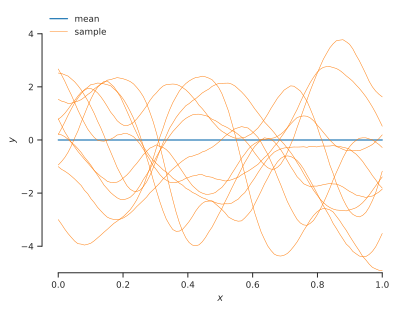

In [3]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel, ScaleKernel

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = 4.0
k.base_kernel.lengthscale = 0.1

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part B - Super smooth function with known ultra-small length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ has as many derivatives as you want and they are all continuous
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximatly of size $\Delta x=0.05$.
+ You think that $f(x)$ is between -3 and 3.

**Answer:**

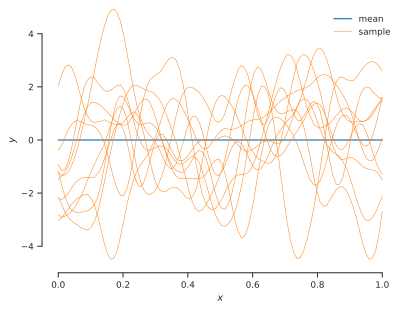

In [ ]:
# Your code here

# Define the covariance function
k = ScaleKernel(RBFKernel())
k.outputscale = (3.0 / 1.96) ** 2
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part C - Continuous function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is continuous, nowhere differentiable.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.MaternKernel`` with $\nu=1/2$.

**Answer:**

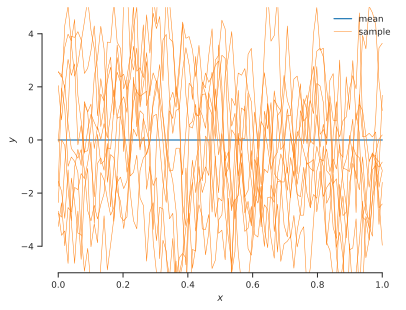

In [ ]:
# Your code here

# Define the covariance function
k = ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5))
k.outputscale = (5.0 / 1.96) ** 2
k.base_kernel.lengthscale = 0.05

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part D - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.5$ of the period.
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.

**Answer:**

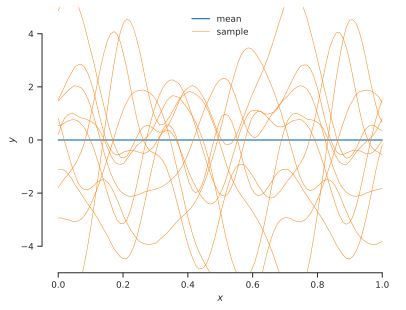

In [ ]:
# Your code here

# Define the covariance function
k = ScaleKernel(gpytorch.kernels.PeriodicKernel())
k.period = 0.1
k.outputscale = (5.0 / 1.96) ** 2
k.base_kernel.lengthscale = 0.5 # in terms of the period

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part E - Smooth periodic function with known length scale

Assume that you hold the following beliefs
+ You know that $f(x)$ is smooth.
+ You know that $f(x)$ is periodic with period 0.1.
+ You don't know if $f(x)$ has a specific trend.
+ You think that $f(x)$ has "wiggles" that are approximately of size $\Delta x=0.1$ of the period (**the only thing that is different compared to D**).
+ You think that $f(x)$ is between -5 and 5.

Hint: Use ``gpytorch.kernels.PeriodicKernel``.


**Answer:**

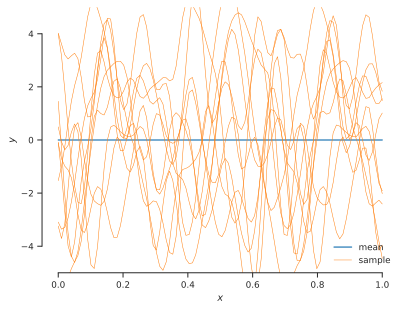

In [ ]:
# Your code here

# Define the covariance function
k = ScaleKernel(gpytorch.kernels.PeriodicKernel())
k.period = 0.1
k.outputscale = (5.0 / 1.96) ** 2
k.base_kernel.lengthscale = 0.1 # in terms of the period

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part F - The sum of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x) + f_2(x)$, where:
    - $f_1(x)$ is smooth with variance 2 and length scale 0.5
    - $f_2(x)$ is continuous, nowhere differentiable with variance 0.1 and length scale 0.1

Hint: Use must create a new covariance function that is the sum of two other covariances.

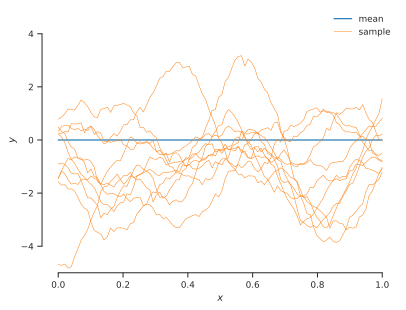

In [ ]:
# Your code here
# first kernel can be RBF
k1 = ScaleKernel(RBFKernel())
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.1

# second kernel of exponential family
k2 = ScaleKernel(gpytorch.kernels.MaternKernel(nu = 0.5))
k2.outputscale = 0.1
k2.base_kernel.lengthscale = 0.1

k = k1 + k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

### Part G - The product of two functions

Assume that you hold the following beliefs
+ You know that $f(x) = f_1(x)f_2(x)$, where:
    - $f_1(x)$ is smooth, periodic (period = 0.1), length scale 0.1 (relative to the period), and variance 2.
    - $f_2(x)$ is smooth with length scale 0.5 and variance 1.

Hint: Use must create a new covariance function that is the product of two other covariances.

ProductKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): PeriodicKernel(
        (raw_lengthscale_constraint): Positive()
        (raw_period_length_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


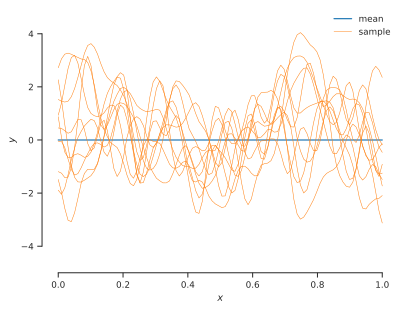

In [ ]:
# Your code here
# Define the covariance function

# first kenel is periodic
k1 = ScaleKernel(gpytorch.kernels.PeriodicKernel())
k1.period = 0.1
k1.outputscale = 2
k1.base_kernel.lengthscale = 0.1 # in terms of the period

# second kernel is RBF
k2 = ScaleKernel(RBFKernel())
k2.base_kernel.lengthscale = 0.5
k2.outputscale = 1

k = k1 * k2

# Define the mean function
mean = gpytorch.means.ConstantMean()
mean.constant = 0.0

# Sample functions
sample_functions(mean, k, nugget=1e-4)

## Problem 2

The National Oceanic and Atmospheric Administration (NOAA) has been measuring the levels of atmospheric CO2 at the Mauna Loa, Hawaii. The measurements start in March 1958 and go back to January 2016.
The data can be found [here](http://www.esrl.noaa.gov/gmd/ccgg/trends/data.html).
The Python cell below downloads and plots the data set.

In [4]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/mauna_loa_co2.txt"
download(url)

In [5]:
data = np.loadtxt('mauna_loa_co2.txt')

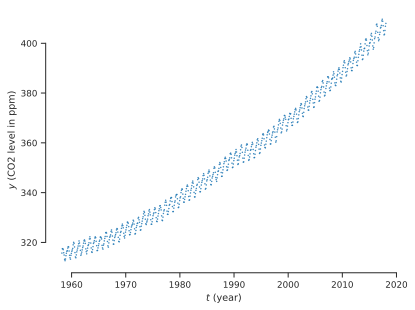

In [6]:
#load data
t = data[:, 2]  #time (in decimal dates)
y = data[:, 4]  #CO2 level (mole fraction in dry air, micromol/mol, abbreviated as ppm)
fig, ax = plt.subplots(1, 1)
ax.plot(t, y, '.', markersize=1)
ax.set_xlabel('$t$ (year)')
ax.set_ylabel('$y$ (CO2 level in ppm)')
sns.despine(trim=True);

Overall, we observe a steady growth of CO2 levels. The wiggles correspond to seasonal changes. Since most of the population inhabits the northern hemisphere, fuel consumption increases during the northern winters, and CO2 emissions follow. Our goal is to study this dataset with Gaussian process regression. Specifically, we would like to predict the evolution of the CO2 levels from Feb 2018 to Feb 2028 and quantify our uncertainty about this prediction.

Working with a scaled version of the inputs and outputs is always a good idea. We are going to scale the times as follows:

$$
t_s = t - t_{\min}.
$$

So, time is still in fractional years, but we start counting at zero instead of 1950.
We scale the $y$'s as:

$$
y_s = \frac{y - y_{\min}}{y_{\max}-y_{\min}}.
$$

This takes all the $y$ between $0$ and $1$.
Here is what the scaled data look like:

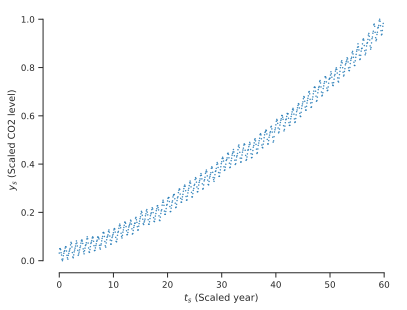

In [7]:
t_s = t - t.min()
y_s = (y - y.min()) / (y.max() - y.min())
fig, ax = plt.subplots(1, 1)
ax.plot(t_s, y_s, '.', markersize=1)
ax.set_xlabel('$t_s$ (Scaled year)')
ax.set_ylabel('$y_s$ (Scaled CO2 level)')
sns.despine(trim=True);

Work with the scaled data in what follows as you develop your model.
Scale back to the original units for your final predictions.

## Part A - Naive approach

Use a zero mean Gaussian process with a squared exponential covariance function to fit the data and make the required prediction (ten years after the last observation).

**Answer:**

**Again, this is done for you so that you have a concrete example of what is requested.**

In [10]:
cov_module = ScaleKernel(RBFKernel())
mean_module = gpytorch.means.ConstantMean()
train_x = torch.from_numpy(t_s).float()
train_y = torch.from_numpy(y_s).float()
naive_model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(naive_model, train_x, train_y)

tensor(0.8545, grad_fn=<NegBackward0>)
tensor(0.7392, grad_fn=<NegBackward0>)
tensor(-0.5164, grad_fn=<NegBackward0>)
tensor(-1.7416, grad_fn=<NegBackward0>)
tensor(-2.1096, grad_fn=<NegBackward0>)
tensor(-2.2474, grad_fn=<NegBackward0>)
tensor(-2.0077, grad_fn=<NegBackward0>)
tensor(-2.2916, grad_fn=<NegBackward0>)
tensor(-2.3049, grad_fn=<NegBackward0>)
tensor(-2.3148, grad_fn=<NegBackward0>)
tensor(-2.3302, grad_fn=<NegBackward0>)
tensor(-2.3334, grad_fn=<NegBackward0>)
tensor(-2.2765, grad_fn=<NegBackward0>)
tensor(-2.3378, grad_fn=<NegBackward0>)
tensor(-2.3401, grad_fn=<NegBackward0>)
tensor(-2.3438, grad_fn=<NegBackward0>)
tensor(-2.3462, grad_fn=<NegBackward0>)
tensor(-2.3476, grad_fn=<NegBackward0>)
tensor(-2.3480, grad_fn=<NegBackward0>)
tensor(-2.3498, grad_fn=<NegBackward0>)
tensor(-2.3520, grad_fn=<NegBackward0>)
tensor(-2.3525, grad_fn=<NegBackward0>)
tensor(-2.3527, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
tensor(-2.3540, grad_fn=<NegBackward0>)
te

Predict everything:

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


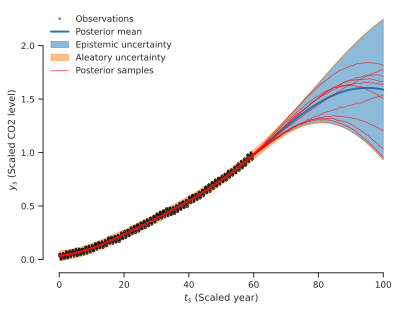

In [11]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=naive_model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

Notice that the squared exponential covariance captures the long terms but fails to capture the seasonal fluctuations. The seasonal fluctuations are treated as noise. This is wrong. You will have to fix this in the next part.

## Part B - Improving the prior covariance

Now, use the ideas of Problem 1 to develop a covariance function that exhibits the following characteristics visible in the data (call $f(x)$ the scaled CO2 level.
+ $f(x)$ is smooth.
+ $f(x)$ has a clear trend with a multi-year length scale.
+ $f(x)$ has seasonal fluctuations with a period of one year.
+ $f(x)$ exhibits small fluctuations within its period.

There is more than one correct answer.

**Answer:**

There is more than one way to build the kernel.
We are going to Assume that the kernel is of the form
$$
f(x) = f_1(x)(f_2(x) + f_3(x))
$$

where $f_1$ captures the overall trend, $f_2$ captures the seasonal variation, and finally $f_3$ captures the smaller fluctuations.

In [12]:
# overall trend
k1 = ScaleKernel(RBFKernel())
k1.base_kernel.lengthscale = 1.0
k1.outputscale = 1.0

# the seasonal variation
k2 = ScaleKernel(gpytorch.kernels.PeriodicKernel())
k2.period = 1.0
k2.base_kernel.lengthscale = 0.1
k2.outputscale = 0.1

# the smaller fluctuations
k3 = ScaleKernel(RBFKernel())
k3.base_kernel.lengthscale = 0.01
k3.outputscale = 0.01

cov_module = gpytorch.kernels.ProductKernel(k1, gpytorch.kernels.AdditiveKernel(k2, k3) )

# data shows a mean function which increases
mean_module = gpytorch.means.LinearMean(input_size = 1)

model = ExactGP(
    train_x,
    train_y,
    mean_module=mean_module,
    covar_module=cov_module
)
train(model, train_x, train_y)

tensor(1953.3033, grad_fn=<NegBackward0>)
tensor(550.4092, grad_fn=<NegBackward0>)
tensor(117.3858, grad_fn=<NegBackward0>)
tensor(14.0789, grad_fn=<NegBackward0>)
tensor(-0.2348, grad_fn=<NegBackward0>)
tensor(-0.2419, grad_fn=<NegBackward0>)
tensor(-0.2436, grad_fn=<NegBackward0>)
tensor(-0.2512, grad_fn=<NegBackward0>)
tensor(0.0928, grad_fn=<NegBackward0>)
tensor(-0.2660, grad_fn=<NegBackward0>)
tensor(-0.2739, grad_fn=<NegBackward0>)
tensor(-0.2905, grad_fn=<NegBackward0>)
tensor(-0.2929, grad_fn=<NegBackward0>)
tensor(-0.2932, grad_fn=<NegBackward0>)
tensor(-0.2981, grad_fn=<NegBackward0>)
tensor(-0.3069, grad_fn=<NegBackward0>)
tensor(-0.3332, grad_fn=<NegBackward0>)
tensor(-0.3934, grad_fn=<NegBackward0>)
tensor(-0.5331, grad_fn=<NegBackward0>)
tensor(-0.8522, grad_fn=<NegBackward0>)
tensor(-1.9222, grad_fn=<NegBackward0>)
tensor(24.3249, grad_fn=<NegBackward0>)
tensor(-1.2775, grad_fn=<NegBackward0>)
tensor(-2.0066, grad_fn=<NegBackward0>)
tensor(-2.0505, grad_fn=<NegBackward0

Plot using the following block:

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


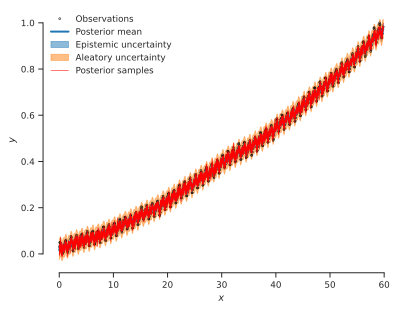

In [13]:
plot_1d_regression(model=model, x_star=train_x);

## Part C - Predicting the future

How does your model predict the future? Why is it better than the naive model?

**Answer:**
*Your answer here*
<br><br>

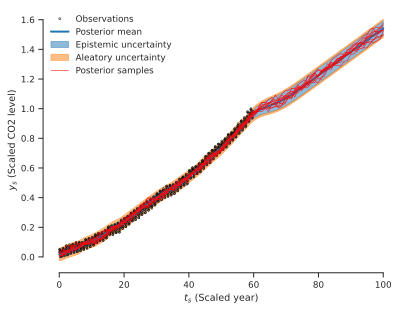

In [14]:
x_star = torch.linspace(0, 100, 100)
plot_1d_regression(model=model, x_star=x_star,
                   xlabel='$t_s$ (Scaled year)', ylabel='$y_s$ (Scaled CO2 level)');

## Part D - Bayesian information criterion

As we have seen in earlier lectures, the Bayesian informationc criterion (BIC), see [this](https://en.wikipedia.org/wiki/Bayesian_information_criterion), can bse used to compare two models.
The criterion says that one should:
+ fit the models with maximum likelihood,
+ and compute the quantity:

$$
\text{BIC} = d\ln(n) - 2\ln(\hat{L}),
$$

where $d$ is the number of model parameters, and $\hat{L}$ the maximum likelihood.
+ pick the model with the smallest BIC.

Use BIC to show that the model you constructed in Part C is indeed better than the naïve model of Part A.

**Answer:**

In [15]:
# Hint: You can find the parameters of a model like this
list(naive_model.hyperparameters())

[Parameter containing:
 tensor([-8.5276], requires_grad=True),
 Parameter containing:
 tensor(0.8225, requires_grad=True),
 Parameter containing:
 tensor(-0.3027, requires_grad=True),
 Parameter containing:
 tensor([[34.8740]], requires_grad=True)]

In [16]:
m = sum(p.numel() for p in naive_model.hyperparameters())
print(m)

4


In [17]:
# Hint: You can find the (marginal) log likelihood of a model like this
mll = gpytorch.mlls.ExactMarginalLogLikelihood(naive_model.likelihood, naive_model)
log_like = mll(naive_model(train_x), train_y)
print(log_like)

tensor(2.3116, grad_fn=<DivBackward0>)


In [18]:
# Hint: The BIC is
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(bic)

tensor(21.6882, grad_fn=<AddBackward0>)


In [19]:
# Your code here

# for trained model

list(model.hyperparameters())

[Parameter containing:
 tensor([-8.5276], requires_grad=True),
 Parameter containing:
 tensor([[0.0159]], requires_grad=True),
 Parameter containing:
 tensor([-0.0469], requires_grad=True),
 Parameter containing:
 tensor(-2.3636, requires_grad=True),
 Parameter containing:
 tensor([[4.9644]], requires_grad=True),
 Parameter containing:
 tensor(-5.1950, requires_grad=True),
 Parameter containing:
 tensor([[0.0278]], requires_grad=True),
 Parameter containing:
 tensor([[-0.4326]], requires_grad=True),
 Parameter containing:
 tensor(-6.3422, requires_grad=True),
 Parameter containing:
 tensor([[-4.6002]], requires_grad=True)]

In [20]:
m = sum(p.numel() for p in model.hyperparameters())
print(m)

10


In [21]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
log_like = mll(model(train_x), train_y)
print(log_like)

tensor(2.7368, grad_fn=<DivBackward0>)


In [22]:
bic = -2 * log_like + m * np.log(train_x.shape[0])
print(bic)

tensor(60.3050, grad_fn=<AddBackward0>)
